# MPPT CUK CONVERTER DESIGN

## Input: Photovoltaic Panel

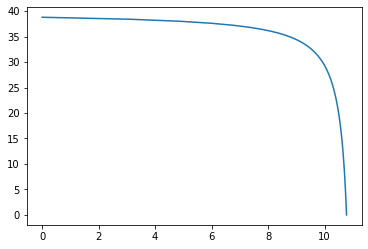

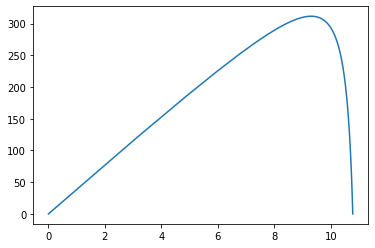

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from libs.panel_factory import FakePanelModel

df_panel = FakePanelModel(Voc=38.8, Isc=8.3, G=1200).data_as_pandas(
    panel_voltage=np.linspace(0, 38.8, num=100, endpoint=True))

plt.plot(df_panel.I, df_panel.V)
plt.show()
plt.plot(df_panel.I, df_panel.P)
plt.show()


# Region of Operation

In [21]:
import numpy as np
from libs.cuk_factory import *

n_bat_cells = 21
v_min_bat_cell = 1.5
v_max_bat_cell = 2.8
v_min_panel = 5
v_max_panel = 40

min_output_voltage = v_min_bat_cell * n_bat_cells
max_output_voltage = v_max_bat_cell * n_bat_cells
output_voltage = np.linspace(min_output_voltage, max_output_voltage, num=100, endpoint=True)
input_voltage, input_current, input_power = df_panel.V, df_panel.I, df_panel.P


cuks = []
for Vo in output_voltage:
    for (Vi, Ii, Pi) in zip(input_voltage, input_current, input_power):
        D = Vo / (Vo + Vi)

        operation_point = OperationPoint(
            output_voltage=Vo,
            input_voltage=Vi,
            duty_cycle=D,
        )

        design_constraints = DesignConstraints(
            switching_frequency=100e3,
            output_power=Pi,
            input_inductor_ripple=40/100,
            output_inductor_ripple=40/100,
            coupling_capacitor_ripple=5/100,
            output_capacitor_ripple=0.1/100,
        )

        cuks.append(IdealCuk(operation_point=operation_point,
                             design_constraints=design_constraints))


/home/joaoantoniocardoso/ZeniteSolar/2022/MCC22/design/modelling/libs/cuk_factory.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  I_L_avg = (D / (1 - D)) * (P_o / V_o)
/home/joaoantoniocardoso/ZeniteSolar/2022/MCC22/design/modelling/libs/cuk_factory.py:60: RuntimeWarning: invalid value encountered in double_scalars
  I_L_avg = (D / (1 - D)) * (P_o / V_o)
/home/joaoantoniocardoso/ZeniteSolar/2022/MCC22/design/modelling/libs/cuk_factory.py:96: RuntimeWarning: invalid value encountered in double_scalars
  L = V_i * D / (f * I_L_pkpk)
/home/joaoantoniocardoso/ZeniteSolar/2022/MCC22/design/modelling/libs/cuk_factory.py:170: RuntimeWarning: divide by zero encountered in double_scalars
  C_esr = V_C_pkpk / I_Lo_pkpk
/home/joaoantoniocardoso/ZeniteSolar/2022/MCC22/design/modelling/libs/cuk_factory.py:65: RuntimeWarning: divide by zero encountered in double_scalars
  L = V_o * (1 - D) / (f * I_L_pkpk)
/home/joaoantoniocardoso/ZeniteSolar/2022/MCC22/design/modelling/libs/cu

,mean,min,max
Li,0.000034,8.981457e-07,0.000187
Lo,0.000082,4.049244e-05,0.000286
Cc,0.000008,2.410579e-07,0.000016
Co,0.000050,6.107051e-07,0.000157
Vo,45.150000,3.150000e+01,58.800000
Vi,19.400000,3.919192e-01,38.408081
D,0.717270,4.505917e-01,0.993379


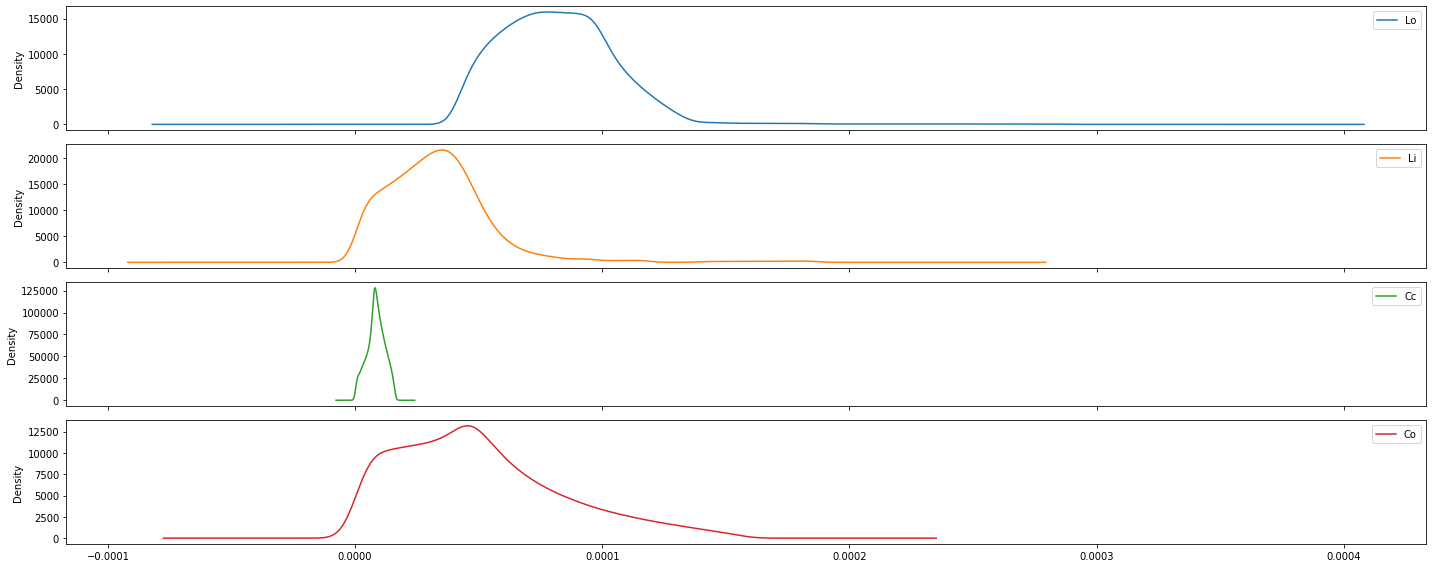

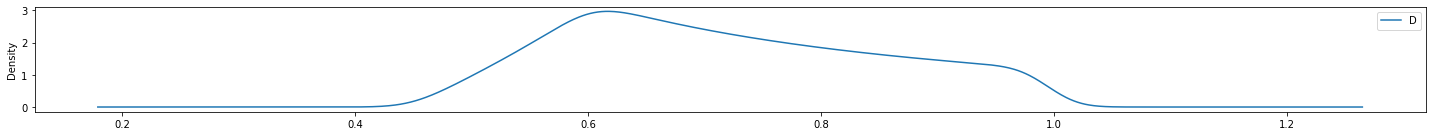

In [89]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.json_normalize([asdict(cuk) for cuk in cuks], sep='.')
df = df.loc[:, (df != 0).any(axis=0)].replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='all').dropna(axis=0, how='any')
df.drop(columns=[col for col in df.columns if '.type' in col], inplace=True)
df.drop(columns=[col for col in df.columns if 'design_constraints' in col], inplace=True)
df.drop(columns=[col for col in df.columns if 'I' in col], inplace=True)
df.drop(columns=[col for col in df.columns if 'V' in col], inplace=True)
df.rename(columns={'input_inductor.value': 'Li',
                   'output_inductor.value': 'Lo',
                   'coupling_capacitor.value': 'Cc',
                   'output_capacitor.value': 'Co',
                   'operation_point.output_voltage': 'Vo',
                   'operation_point.input_voltage': 'Vi',
                   'operation_point.duty_cycle': 'D'}, inplace=True)
# df.set_index([col for col in df.columns if 'operation_point' in col], inplace=True)

df[['Lo', 'Li', 'Cc', 'Co']].plot.kde(subplots=True, figsize=(20, 4*2))
plt.tight_layout()

df[['D']].plot.kde(subplots=True, figsize=(20, 2))
plt.tight_layout()

df.describe().transpose()[['mean', 'min', 'max']]

In [90]:
component_values = df[['Li', 'Lo', 'Cc', 'Co']].max().apply(np.around, args=(6,)).to_dict()
component_values

{'Li': 0.000187, 'Lo': 0.000286, 'Cc': 1.6e-05, 'Co': 0.000157}